In [1]:
import math
import numpy as np
import pandas as pd
import os
import sys

import time
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 

import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset


In [2]:
os.getcwd()

'/home/dhruv/Documents/Computer Vision/CV_Project/ProGAN_learning'

In [3]:
os.listdir(os.getcwd())

['clothes_GAN.ipynb', 'data.ipynb', 'Data_PROGAN', 'saved_examples']

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.get_device_name(0)

(1, 0, 'NVIDIA GeForce RTX 4090')

In [6]:
DATASET = "/home/dhruv/Documents/Computer Vision/CV_Project/ProGAN_learning/Data_PROGAN"
START = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

LR  = 1e-3
BS = [32, 32, 32, 16, 16, 16]

image_size = 128

CHANNELS = 3
Z_DIM = 256

IN_CHANNELS  = 256
LAMBDA_GP = 10
PG = [30]*len(BS)



Using device: cuda


In [7]:
def get_loader(img_size):
    
    transform = transforms.Compose(
        [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]
    )
    
    batch_size = BS[int(math.log2(img_size/4))]  ## 0, 1, 2, 3
    
    dataset = datasets.ImageFolder(root= DATASET, transform=transform)
    
    loader = DataLoader(
        dataset,
        batch_size,
        shuffle= True
    )
    
    return loader, dataset

In [8]:
def check_data_loader():
    loader_data, data = get_loader(128)
    data_iter = iter(loader_data)
    images, laebls = next(data_iter)
    print(f"Image batch shape: {images.size()}")
    print(f"Image label shape: {laebls.size()}")
    
    _, ax = plt.subplots(3,3, figsize=(8,8))
    
    plt.suptitle("Some real images")
    
    ind = 0 
    
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((images[ind].permute(1,2,0).cpu()+1)/2)
            ind += 1
            

Image batch shape: torch.Size([16, 3, 128, 128])
Image label shape: torch.Size([16])


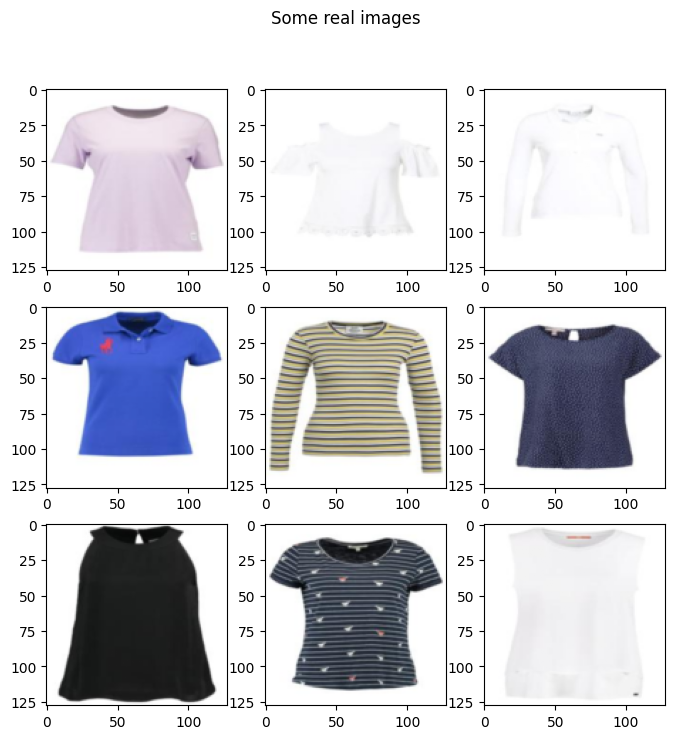

In [9]:
check_data_loader()

In [10]:
class WSconv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bais=True):
        super(WSconv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2/((in_channels) * (kernel_size) * (kernel_size)))**0.5
        self.bias = self.conv.bias 
        self.conv.bias = None


        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)        
    
    def forward(self, x):
        return self.conv(x*self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)
    

In [11]:
class pixelNorm(nn.Module):
    def __init__(self):
        super(pixelNorm,self).__init__()
        self.eps = 1e-8


    def forward(self, x):
        return x/ torch.sqrt(torch.mean(x**2, dim=1, keepdim= True) + self.eps)

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, ouput_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        
        self.use_px = use_pixelnorm
        self.conv1 = WSconv2d(in_channels, ouput_channels)
        self.conv2 = WSconv2d(in_channels, ouput_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.px = pixelNorm()
        
    def forward(self, x):
        x = self.leaky(self.conv1(x))
        if self.use_px:
            x = self.px(x)
        x = self.leaky(self.conv2(x))
        if self.use_px:
            x = self.px(x)
        return x

In [13]:
factors = [1, 1, 1, 1, 1/2, 1/4, 1/8, 1/16, 1/32]

class Generator(nn.Module):
    
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()
        
        self.initial = nn.Sequential(
            pixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSconv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            pixelNorm()
            )
        
        self.initial_rgb = WSconv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0)
        
        self.prog_blocks, self.rgb_layers = (nn.ModuleList([]), nn.ModuleList([self.initial_rgb]))
        
        for i in range(len(factors)-1):
            conv_ic_c = int(in_channels * factors[i])
            conv_oc_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(ConvBlock(conv_ic_c, conv_oc_c))
            self.rgb_layers.append(WSconv2d(conv_oc_c, img_channels, kernel_size=1, stride=1, padding=0))
            
    def fad_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha) *upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)
        
        if steps == 0:
            return self.initial_rgb(out)
        
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode='nearest')
            out = self.prog_blocks[step](upscaled)
            
        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out = self.rgb_layers[steps](out)
        
        return self.fad_in(alpha, final_upscaled, final_out)
    

In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)
        
        
        
        for i in range(len(factors)-1,0,-1):
            conv_in = int(in_channels*factors[i])
            conv_out = int(in_channels*factors[i-1])
            
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(WSconv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0))
            
            
        self.initial_rgb = WSconv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0)
        
        self.rgb_layers.append(self.initial_rgb)
        
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.final_block = nn.Sequential(
        
            WSconv2d(in_channels+1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSconv2d(in_channels, in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            WSconv2d(in_channels, 1, kernel_size=1, stride=1, padding=0)
        )
        
        
    def fad_in(self, alpha, downscaled, out):
        return alpha*out + (1-alpha)*downscaled
    
    def minibatch_std(self, x):
        batch_statistics = (torch.std(x, dim=0).mean().repeat(x.shape[0], 1 , x.shape[2], x.shape[3]))
        
        return torch.cat([x,batch_statistics], dim=1)
    
    def forward(self, x, alpha, steps):
        cur_step = len(self.prog_blocks) - steps
        
        out = self.leaky(self.rgb_layers[cur_step](x))
        
        if steps == 0:
            out = self.minibatch_std(out)
            
            return self.final_block(out).view(out.shape[0], -1)
        
        downscaled = self.leaky(self.rgb_layers[cur_step+1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))
        
        out = self.fad_in(alpha, downscaled, out)
        
        for step in range(cur_step+1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)
            
        out = self.minibatch_std(out)
        
        return self.final_block(out).view(out.shape[0], -1)

In [15]:
def generate_examples(gen, steps, n= 100):
    
    gen.eval()
    alpha = 1
    
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM, 1, 1).to(device=DEVICE)
            img = gen(noise, alpha, steps)
            
            if not os.path.exists(f"saved_examples/steps{steps}"):
                os.makedirs(f"saved_examples/steps{steps}")
                
                save_image(img*0.5 + 0.5, f"saved_examples/steps{steps}/image_{i}.png")
                
    gen.train()
    
    

In [16]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):

    BATCH_size, C, H, W = real.shape
    beta = torch.rand((BATCH_size, 1, 1, 1)).repeat(1, C, H, W).to(device)
    
    interpolated_images = real*beta + fake.detach()*(1-beta)
    
    interpolated_images.requires_grad_(True)
    
    mixed_scores = critic(interpolated_images, alpha, train_step)
    
    gradient = torch.autograd.grad(
        inputs = interpolated_images,
        outputs = mixed_scores,
        grad_outputs = torch.ones_like(mixed_scores),
        create_graph=  True,
        retain_graph= True
        
    )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1)**2)
    
    
    return gradient_penalty

In [17]:
def train_fun(critic, gen, loader, dataset, step, alpha, optimizer_critic, optimizer_gen):
    loop = tqdm.tqdm(loader)
    
    for batch_idx, (real,_) in enumerate(loop):
        
        real = real.to(DEVICE)
        
        curr_batch_size = real.shape[0]
        
        noise = torch.randn(curr_batch_size, Z_DIM, 1, 1).to(DEVICE)
        
        fake = gen(noise, alpha, step)
        
        critic_real = critic(real, alpha, step)
        
        critic_fake = critic(fake.detach(), alpha, step)
        
        
        gp = gradient_penalty(critic, real, fake, alpha, step, device= DEVICE)
        
        loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake) + LAMBDA_GP*gp + (1e-3)*torch.mean(critic_real**2))
        
        critic.zero_grad()
        loss_critic.backward()
        optimizer_critic.step()
        
        gen_fake = critic(fake, alpha, step)
        loss_gen = - torch.mean(gen_fake)
        
        critic.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
        
        alpha += curr_batch_size / (PG[step]*0.5*len(dataset))
        
        alpha = min(alpha, 1)
        
        loop.set_postfix(gp = gp.item(), loss_critic= loss_critic.item())
        
        
    return alpha

In [ ]:
gen = Generator(Z_DIM, IN_CHANNELS, CHANNELS).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS).to(DEVICE)

optimizer_gen = optim.Adam(gen.parameters(), lr=LR, betas=(0.0,0.99))

optimizer_critic = optim.Adam(critic.parameters(), lr=LR, betas=(0.0, 0.99))

gen.train()
critic.train()


step = int(math.log2(START/4))


for num_epoch in PG[step:]:
    alpha = 1e-6
    loader, dataset = get_loader(4*2**step)
    print(f"Currnt image Size : {4*2**2}")
    
    for epoch in range(num_epoch):
        print(f"Epoch {epoch+1} of {num_epoch}")
        alpha = train_fun(critic, gen, loader, dataset, step, alpha, optimizer_critic, optimizer_gen)
        
        generate_examples(gen, step, n =100)
        
    step += 1
        

Currnt image Size : 16
Epoch 1 of 30


100%|██████████| 508/508 [00:06<00:00, 77.53it/s, gp=4.47e+7, loss_critic=-4.61e+8]


Epoch 2 of 30


100%|██████████| 508/508 [00:06<00:00, 80.19it/s, gp=2.63e+9, loss_critic=-2.73e+10]


Epoch 3 of 30


 33%|███▎      | 170/508 [00:02<00:04, 80.08it/s, gp=8.8e+9, loss_critic=-8.96e+10]  